1. Installing required modules

In [1]:
# Installs required modules

!pip install -r requirements.txt

2. Importing required modules

In [2]:
# Imports required modules
import torch
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import set_seed
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import json
import os
import shutil
from joblib import dump, load

# Sets seeds to zero
set_seed(0)
torch.manual_seed(0)
np.random.seed(0)

3. Defining utility functions for the entire project

In [3]:
def prepare_dataset(working_dir=os.getcwd()):
  """This function prepares and returns the dataset for the project.

  Arguments
  ---------
  working_dir : str
    A string value representing the current working directory 
  
  Returns
  ---------
  project_dataset : datasets.dataset_dict.DatasetDict
    A Dataset dictionary object containing the train, validation, and test data
  """

  train_file = working_dir + "/train_dataset_processed.csv"
  test_file = working_dir + "/test_dataset_processed.csv"

  data_files = {"train": train_file, "test": test_file}
  class_names = ["negative", "neutral", "positive"]
  data_columns = Features({"label": ClassLabel(names=class_names), "text": Value("string")})
  original_data = load_dataset("csv", data_files=data_files, column_names=["label", "text"], features=data_columns)

  train_valid_data = original_data["train"].train_test_split(test_size=0.2)
  train_dataset = train_valid_data["train"]
  valid_dataset = train_valid_data["test"]
  project_dataset = DatasetDict({
      "train": train_dataset,
      "valid": valid_dataset,
      "test": original_data["test"]})

  # Removing empty text entries
  project_dataset = project_dataset.filter(lambda example: example["text"] != None)
  return project_dataset


def plot_confusion_matrix(y_preds, y_true, labels, title):
  """This function displays the confusion matrix for provided predictions by a classifier.

  Arguments
  ---------
  y_preds : numpy.ndarray
    Predictions by a classifier
  y_true : numpy.ndarray
    Labels corresponding to the predictions in y_preds
  labels : list
    Label names to be used for the confusion matrix
  title : str
    Title to be used for the confusion matrix

  """

  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix for " + title)
  plt.show()

def print_classification_report(y_preds, y_true, title):
  """This function displays the classification report for provided predictions by a classifier.

  Arguments
  ---------
  y_preds : numpy.ndarray
    Predictions by a classifier
  y_true : numpy.ndarray
    Labels corresponding to the predictions in y_preds
  title : str
    Title to be used for the confusion matrix

  """

  labels = ["negative", "neutral", "positive"]
  plot_confusion_matrix(y_preds, y_true, labels, title)
  print("\n")
  print("Classification report for " + title)
  acc = accuracy_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds, average="weighted")
  prec = precision_score(y_true, y_preds, average="weighted")
  rec = recall_score(y_true, y_preds, average="weighted")
  
  print("-" * 75)
  print("Accuracy: %.2f%%" % (acc * 100))
  print("Precision: %.2f%%" % (prec * 100) )
  print("Recall: %.2f%%" % (rec * 100))
  print("F1 score: %.2f%%" % (f1 * 100) )
  print("-" * 75)
  print("\n\n")

def display_data_properties(dataset):
  """This function displays data distribution among different classes in the dataset.

  Arguments
  ---------
  dataset : datasets.dataset_dict.DatasetDict
    A Dataset dictionary object containing one or more of the following -  train, validation, and test data

  """

  # Uses pandas to display the data distribution
  dataset.set_format(type="pandas")
  train_df = dataset["train"][:]
  valid_df = dataset["valid"][:]
  test_df = dataset["test"][:]

  def label_int2str(row):
    """
    This function converts a label's integer value to a string value.

    Arguments
    ---------
    row : int
      Integer value of the label
    
    """

    return dataset["train"].features["label"].int2str(row)

  train_df["label_name"] = train_df["label"].apply(label_int2str)
  valid_df["label_name"] = valid_df["label"].apply(label_int2str)
  test_df["label_name"] = test_df["label"].apply(label_int2str)

  print("Displaying the first 5 examples of the training dataset: ")
  print("-" * 75)
  print(train_df.head())
  print("-" * 75)

  # Displays the frequency of classes in the training data
  train_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in training data")
  plt.show()

  # Displays the frequency of classes in the validation data
  plt.figure()
  valid_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in validation data")
  plt.show()

  # Displays the frequency of classes in the test data
  plt.figure()
  test_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in test data")
  plt.show()

  # Resetting the dataset format
  dataset.reset_format()

# 2. Transformers section

## 2.1. Completing project setup for transformer models

The below code cell is used to provide the value for "model_checkpoint" as one of the following: "distilbert-base-uncased" or "bert-base-uncased".

This sets the pretrained transformer model to be used for the current execution of the model as either BERT or DistilBERT.

In [4]:
model_checkpoint = "distilbert-base-uncased"    # Sets the model to be used for the current execution of the project

working_dir = os.getcwd()               # Sets the working directory for the project
project_dataset = prepare_dataset()     # Prepares project dataset to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Uses GPU if available otherwise uses CPU

# Creates the class weights tensor - used for cross entropy calculation
class_samples = [9023, 12366, 6416]
class_weights = [1 - (x / sum(class_samples)) for x in class_samples]
class_weights = torch.FloatTensor(class_weights).to(device)

# Creates the output directory for the current model (if one does not exist)
if not os.path.exists(working_dir + "/output-" + model_checkpoint):
  os.makedirs(working_dir + "/output-" + model_checkpoint)
model_output_dir = working_dir + "/output-" + model_checkpoint

# Creates a directory to save the best models (if onr does not exist)
if not os.path.exists(working_dir + "/best_models/" + model_checkpoint):
  os.makedirs(working_dir + "/best_models/" + model_checkpoint)

# Instantiates a tokenizer based on the provided name of the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Using custom data configuration default-16c2d781b0fc69a4
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d0fdde8cd0befd57.arrow and /root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-5a6a84d48da3c017.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eb48b24967eabe56.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-01298554c7bdc865.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-16c2d781b0fc69a4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-6276f121afa39ba1.arrow


Verifying the project setup

In [5]:
assert model_checkpoint == "distilbert-base-uncased" or model_checkpoint == "bert-base-uncased", "Expected model_checkpoint to be either \"distilbert-base-uncased\" or \"bert-base-uncased\""
assert isinstance(working_dir, str), "Expected working_dir to be a string value"
assert working_dir == os.getcwd(), "Expected working_dir to be the current working dir"
assert isinstance(project_dataset, DatasetDict), "Expected project_dataset to be a datasets.dataset_dict.DatasetDict"
assert isinstance(class_samples, list), "Expected class_samples to be a list"
assert isinstance(class_weights, torch.Tensor), "Expected class_weights to be a torch.Tensor"
assert model_output_dir == working_dir + "/output-" + model_checkpoint, "Unexpected value for model_outpur_dir"
print("Project setup is OK.")

Project setup is OK.


## 2.2 Preparing input data

2.2.1. Tokenizating the input

In [28]:
def encode_dataset(tokenizer, project_dataset):
  """This function uses the provided tokenizer to tokenize and encode samples in project_dataset as their numerical vectors.

  Arguments
  ---------
  tokenizer : 
    The tokenizer instantiated based on the pretrained model being used for the project
  project_dataset : datasets.dataset_dict.DatasetDict
    A Dataset dictionary object containing one or more of the samples and their labels
  
  Returns
  ---------
  dataset_encoded : datasets.dataset_dict.DatasetDict
    The encoded dataset containing encoded samples and their labels
  """
  
  # Initializes the tokenizer
  tokenizer = tokenizer

  # Defines the tokenization function
  def tokenize(batch):
    """This function applies tokenizer to a batch of samples

    Arguments
    ---------
    batch : datasets.arrow_dataset.Batch
      A batch of samples
    """
    return tokenizer(batch["text"], padding=True, truncation=True)
    
  # Applies the tokenize function to the provided project_dataset
  return project_dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded = encode_dataset(tokenizer, project_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Verifying encoded dataset

In [29]:
assert "input_ids" in dataset_encoded["train"].column_names, "dataset_encoded is not correctly formed"
assert "attention_mask" in dataset_encoded["train"].column_names, "dataset_encoded is not correctly formed"
assert "text" in dataset_encoded["train"].column_names, "dataset_encoded is not correctly formed"
assert "label" in dataset_encoded["train"].column_names, "dataset_encoded is not correctly formed"
print("Encoded dataset formed correctly.")

Encoded dataset formed correctly.


## 2.3 Training a classifier

### 2.3.1 Training a classifier using feature extraction

2.3.1.1 Extracting the last hidden states

In [30]:
def extract_hidden_states_features(model_checkpoint, dataset_encoded, tokenizer):
  """This function passes the encoded input through a pretrained model and extracts and returns the last hidden states.

  Arguments
  ---------
  model_checkpoint : str
    The name of the pretrained model to be used
  dataset_encoded : datasets.dataset_dict.DatasetDict
    The encoded dataset containing encoded samples and their labels
  tokenizer : 
    The tokenizer instantiated based on the pretrained model being used for the project
  
  Returns
  ---------
  dataset_hidden : datasets.dataset_dict.DatasetDict
    The dataset containing the last hidden states and labels
  """

  model = AutoModel.from_pretrained(model_checkpoint).to(device)

  def extract_hidden_states(batch):
    """This function extracts the hidden states for a batch of samples

    Arguments
    ---------
    batch : dict
      A batch of samples
    """
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
      last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

  # Extracting hidden states for all samples using map
  dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  return dataset_hidden

dataset_hidden = extract_hidden_states_features(model_checkpoint, dataset_encoded, tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Verifying the extracted hidden states

In [31]:
assert "input_ids" in dataset_hidden["train"].column_names, "dataset_hidden is not correctly formed"
assert "attention_mask" in dataset_hidden["train"].column_names, "dataset_hidden is not correctly formed"
assert "text" in dataset_hidden["train"].column_names, "dataset_hidden is not correctly formed"
assert "label" in dataset_hidden["train"].column_names, "dataset_hidden is not correctly formed"
assert "hidden_state" in dataset_hidden["train"].column_names, "dataset_hidden is not correctly formed"
print("Hidden states dataset formed correctly.")

Hidden states dataset formed correctly.


2.3.1.2 Creating train, validation, test datasets of the hidden states as required for the classifier

In [8]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

Verifying the created feature matrix

In [35]:
assert len(X_train) == len(y_train), "The length of X_train and y_train must be the same"
assert len(X_valid) == len(y_valid), "The length of X_valid and y_valid must be the same"
assert len(X_test) == len(y_test), "The length of X_test and y_test must be the same"
print("Feature matrix is OK.")

Feature matrix is OK.


2.3.1.3 Training an MLP classifier using the hidden states and labels

In [36]:
mlp = MLPClassifier(random_state=0,
                    validation_fraction=0.2, 
                    early_stopping=True)
mlp.fit(X_train, y_train)
print("Training accuracy: %.2f %%" % (mlp.score(X_train, y_train) * 100))
print("Validation accuracy: %.2f %%"  % (mlp.score(X_valid, y_valid) * 100))

Training accuracy: 51.87 %
Validation accuracy: 48.34 %


2.3.1.4 Generating results to document a baseline

Plots the training loss and validation accuracy of the MLP model

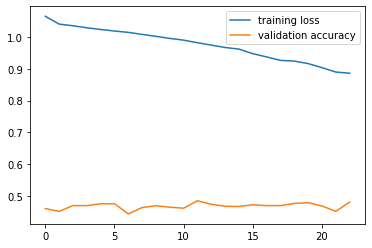

In [37]:
plt.plot(mlp.loss_curve_, label="training loss")
plt.plot(mlp.validation_scores_, label="validation accuracy")
plt.legend();

Provides the confusion matrix and classification report for validation data and test data of the project

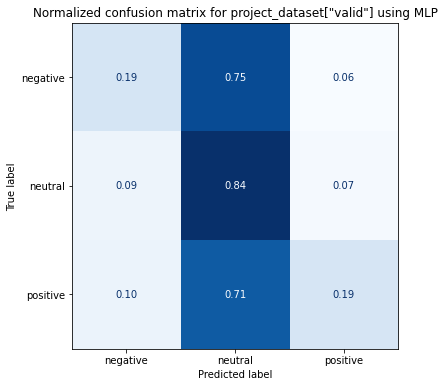



Classification report for project_dataset["valid"] using MLP
---------------------------------------------------------------------------
Accuracy: 48.34%
Precision: 48.00%
Recall: 48.34%
F1 score: 42.61%
---------------------------------------------------------------------------





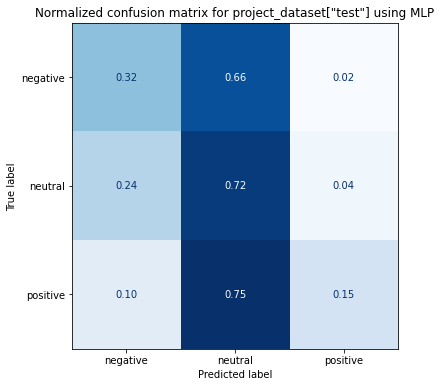



Classification report for project_dataset["test"] using MLP
---------------------------------------------------------------------------
Accuracy: 38.43%
Precision: 52.89%
Recall: 38.43%
F1 score: 36.11%
---------------------------------------------------------------------------





In [38]:
y_preds_v = mlp.predict(X_valid)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using MLP")

y_preds_t = mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using MLP")

2.3.1.5 Saving the trained model

In [39]:
mlp_save_filename = working_dir + "/best_models/mlp.joblib"
dump(mlp, mlp_save_filename)

['/content/best_models/mlp.joblib']

2.3.1.5 Loading saved model and testing performance on test data

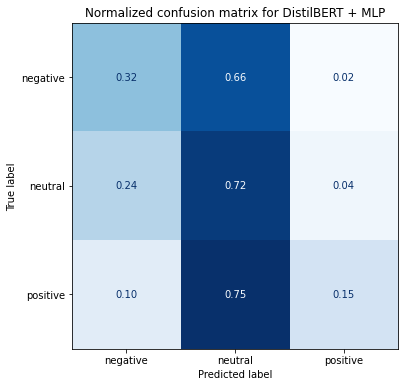



Classification report for DistilBERT + MLP
---------------------------------------------------------------------------
Accuracy: 38.43%
Precision: 52.89%
Recall: 38.43%
F1 score: 36.11%
---------------------------------------------------------------------------





In [40]:
loaded_mlp = load(working_dir + "/best_models/mlp.joblib")
y_preds_t = loaded_mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "DistilBERT + MLP")

### 2.3.2 Training a classifier using fine tuning

2.3.2.1 Defining functions required for training a classifier by fine-tuning a transformer model

In [10]:
# Defining the performance metrics that will be used to evaluate our model's performance during fine-tuning
def compute_metrics(pred):
  """This function computes and returns the accuracy, precision, recall, F1 score, and categorical cross entropy loss metrics for the provided predictions.

  Arguments
  ---------
  pred : 
    Object containing the predictions and labels for which the metrics are to be calculated
  """

  print("Tpye of pred: ", type(pred))
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
  loss_val = loss_fct(torch.from_numpy(pred.predictions).to(device), torch.from_numpy(labels).to(device))
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  prec = precision_score(labels, preds, average="weighted")
  rec = recall_score(labels, preds, average="weighted")
  return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1, "loss": loss_val}


def model_init():
  dropout_val = 0.3
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)
      dropout_val = prev_hp["dropout"]
      print("Found previously searched dropout value: ", dropout_val)
  except:
    print("No previous dropout value found. Using default setting of", dropout_val)

  if model_checkpoint == "distilbert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             dropout=dropout_val,
                                                             attention_dropout=dropout_val,
                                                             qa_dropout=dropout_val).to(device))
  elif model_checkpoint == "bert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             attention_probs_dropout_prob=dropout_val,
                                                             hidden_dropout_prob=dropout_val,
                                                             classifier_dropout=dropout_val).to(device))

def compute_objective(metrics):

  return metrics["eval_loss"]

2.3.2.2 Defining the project trainer class

In [11]:
class ProjectTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(output_dir=model_output_dir,
                                  evaluation_strategy="steps",
                                  logging_strategy="steps",
                                  eval_steps=500,
                                  disable_tqdm=False,
                                  logging_dir=model_output_dir + "/logs",
                                  save_total_limit=1,
                                  load_best_model_at_end=True)

trainer = ProjectTrainer(args=training_args,
                            tokenizer=tokenizer,
                            train_dataset=dataset_encoded["train"],
                            eval_dataset=dataset_encoded["valid"],
                            model_init=model_init,
                            compute_metrics=compute_metrics)

No previous dropout value found. Using default setting of 0.3


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_v

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.pr

2.3.2.3 Performing hyperparameter tuning for the model

In [42]:
def project_hyperparameter_tuning(num_trials=20):

  hp_search_space = dict()
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)
    plr = prev_hp["learning_rate"]

    hp_search_space= {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(plr * 0.1, plr * 10),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }
  except:
    hp_search_space = {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }

  if model_checkpoint == "distilbert-base-uncased":
    hp_search_space["dropout"] = tune.uniform(0.1, 0.3)
    hp_search_space["attention_dropout"] = tune.uniform(0.1, 0.3)
    hp_search_space["qa_dropout"] = tune.uniform(0.1, 0.3)
  elif model_checkpoint == "bert-base-uncased":
    hp_search_space["attention_probs_dropout_prob"] = tune.uniform(0.1, 0.3)
    hp_search_space["hidden_dropout_prob"] = tune.uniform(0.1, 0.3)
    hp_search_space["classifier_dropout"] = tune.uniform(0.1, 0.3)

  best_trial = None
  try:
    best_trial = trainer.hyperparameter_search(hp_space=lambda _: hp_search_space,
                                             compute_objective=compute_objective,
                              direction="minimize",
                              backend="ray",
                              n_trials=num_trials,
                              search_alg=HyperOptSearch(metric="objective", mode="min"),
                              scheduler=ASHAScheduler(metric="objective", mode="min"),
                              local_dir=model_output_dir + "/ray_asha_results_bert",
                              log_to_file=True)

    save_best_model = False
    if "objective" not in hp_search_space:
      save_best_model = True
    if ("objective" in hp_search_space) and (hp_search_space["objective"] > best_trial.objective):
      print("New best hyperparameters found.")
      save_best_model = True

    if save_best_model == True:
      save_model_dir = working_dir + "/best_models/" + model_checkpoint
      for f in os.listdir(save_model_dir):
          os.remove(os.path.join(save_model_dir, f))

      best_run_dir = model_output_dir + "/run-" + best_trial.run_id
      best_model_checkpoint = sorted(os.listdir(best_run_dir))[-1]
      copy_model_dir = os.path.join(best_run_dir, best_model_checkpoint)

      for f in os.listdir(copy_model_dir):
        shutil.copy(os.path.join(copy_model_dir, f), save_model_dir)
      shutil.make_archive(save_model_dir, 'zip', save_model_dir)

      print("Saved model associated with the new best hyperparameters in this directory: ", save_model_dir)
      print("Download the zip file to use the model later.")
    else:
      print("Could not find better hyperparameters in this search.")

    for f in os.listdir(model_output_dir):
      path = os.path.join(model_output_dir, f)
      try:
        shutil.rmtree(path)
      except OSError:
        os.remove(path)
    print("Cleared all files from this hyperparameter search from the following directory: ", model_output_dir)

    hp_values = best_trial.hyperparameters
    hp_values["objective"] = best_trial.objective
    hp_values_json = json.dumps(hp_values)
    with open(model_output_dir + "/model_hp_values.json", "w") as f:
      f.write(hp_values_json)
    print("New hyperparameters written to " + model_output_dir + "/model_hp_values.json")
  except:
    print("Hyperparameter search did not complete successfully.")

  return best_trial

current_best_trial = project_hyperparameter_tuning()
print("Best hyperparameters from this search: ", current_best_trial)

Hyperparameter search did not complete successfully.
Best hyperparameters from this search:  None


2.3.2.4 Training the model with the last best set of hyperparameters found.

This function is written because it was observed that sometimes the hyperparameter tuning phase does not complete successfully due to memory related issues. This function allows us work with any improved hyperparameters found during unsuccessful hyperparameter tuning attempts by manually going through the logs.

In [ ]:
def train_with_last_best_hyperparameters():
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      hp_values = json.load(f)
    print("Set trainer.args using previous hyperparamter search results.")
  except:
    hp_values = dict()
    hp_values["learning_rate"] = 1.5544610095816334e-05
    hp_values["num_train_epochs"] = 2
    hp_values["per_device_train_batch_size"] = 64
    hp_values["seed"] = 25
    hp_values["weight_decay"] = 0.1
    hp_values["dropout"] = 0.12078133498900412
    print("No previous hyperparameter search results found. Manually setting the hyperparameter values.")

  for n, v in hp_values.items():
    if n == "seed":
      v = int(v)
    setattr(trainer.args, n, v)
  setattr(trainer.args, "callbacks", [EarlyStoppingCallback(early_stopping_patience=3)])

  trainer.train()

  model_save_path = model_output_dir +  "/best_model"
  tokenizer.save_pretrained(model_save_path)
  trainer.save_model(model_save_path)

  train_losses = list()
  validation_losses = list()

  for entry in trainer.state.log_history:
    if "loss" in entry:
      train_losses.append(entry["loss"])
    if "eval_loss" in entry:
      validation_losses.append(entry["eval_loss"])

  plt.plot(train_losses, color="blue")
  plt.plot(validation_losses, color="red")
  plt.ylim(-0.05, 2)
  plt.xlabel("Steps")
  plt.ylabel("loss")
  plt.legend(["train_loss", "validation_loss"])
  plt.title("Loss every 500 steps")
  plt.show()

train_with_last_best_hyperparameters()

No previous hyperparameter search results found. Manually setting the hyperparameter values.
No previous dropout value found. Using default setting of 0.3


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.3,
  "dim": 768,
  "dropout": 0.3,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.3,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading we

Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

2.3.2.5 Generating results

Provides the confusion matrix and classification report for validation data and test data of the project

In [ ]:
y_valid = np.array(dataset_encoded["valid"]["label"])
validation_predictions_all = trainer.predict(dataset_encoded["valid"])
y_preds_v = np.argmax(validation_predictions_all.predictions, axis=1)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using finetuned " + model_checkpoint)

y_test = np.array(dataset_encoded["test"]["label"])
test_predictions_all = trainer.predict(dataset_encoded["test"])
y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using finetuned " + model_checkpoint)

2.3.2.5 Loading saved model and testing performance on test data

Didn't find file /content/best_models/bert-base-uncased/added_tokens.json. We won't load it.
loading file /content/best_models/bert-base-uncased/vocab.txt
loading file /content/best_models/bert-base-uncased/tokenizer.json
loading file None
loading file /content/best_models/bert-base-uncased/special_tokens_map.json
loading file /content/best_models/bert-base-uncased/tokenizer_config.json
loading configuration file /content/best_models/bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "/content/best_models/bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2":

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1301
  Batch size = 8


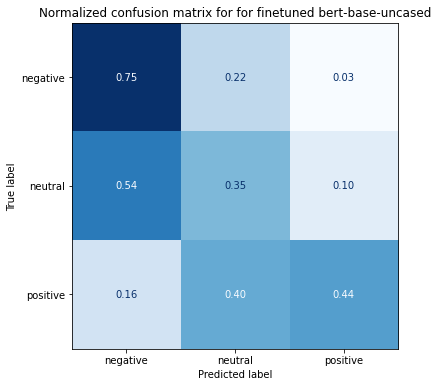



Classification report for for finetuned bert-base-uncased
---------------------------------------------------------------------------
Accuracy: 53.34%
Precision: 56.55%
Recall: 53.34%
F1 score: 53.06%
---------------------------------------------------------------------------





In [12]:
def evaluate_test_data_using_saved_model(dataset):
  # Load model
  try:
    model_load_path = working_dir +  "/best_models/" + model_checkpoint 
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_load_path)
    loaded_m = (AutoModelForSequenceClassification.from_pretrained(model_load_path, num_labels=3).to(device))
    trainer = ProjectTrainer(model=loaded_m)

    dataset_encoded = encode_dataset(loaded_tokenizer, dataset)
    y_test = np.array(dataset_encoded["label"])
    labels = dataset.features["label"].names

    test_predictions_all = trainer.predict(dataset_encoded)
    y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
    print_classification_report(y_preds_t, y_test, "for finetuned " + model_checkpoint)
  except FileNotFoundError:
    print("Could not load a model from the provided path.")
  except Exception as e:
    print("Could not complete the opration because of the following error: ", e)
evaluate_test_data_using_saved_model(project_dataset["test"])